### This script will plot composite average PDSI, Precipitation, and Temperature anomaly maps based on early Grape Harvest Dates.

* This script will generate composite average maps of climate for extreme early harvest years from 1600-1980. This will use the climate reconstructions of Luterbacher and Cook.
* We'll start by resetting the session and just importing the modules that we need.

In [1]:
reset -f

In [2]:
# Setup the Analysis
import calendar
import numpy as np
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from mpl_toolkits.basemap import Basemap, cm
from IPython.display import display

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For plotting a rectangle on the maps
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    

* Here, we set the baseline variables that we need. This includes the baseline period for averaging (1600-1901, same baseline for GHD anomalies), the threshold for early harvests in GHD-Core (-7.67 days early, 1 st.dev. over baseline interval), and boundaries for drawing the core region rectangle.

In [3]:
# Interval to sample from
yr_samp = np.arange(1981,2008);

# Rectangle Boundaries
lonmin=-2; lonmax=8; latmin=43; latmax=51

# baseline period for anomaly calculation. Should be same as base period in setp01_proc_ghd.py
base_period = np.arange(1600,1901)   

# Set threshold GHD anomaly for compositing
harvest_thresh = -7.67;  # about 1 standard deviation for GHDmean or GHD core

# GHD Data to Analyze
ghd_name = 'GHDcore'

* Here, we will load in all the datasets: the GHD anomalies and the various paleoclimate reconstructions.

In [4]:
# Load and properly format wine data
infile= '../data/ghd_anom_doy_v02.csv'   # Name of the original data file

df=pd.read_csv(infile)

# Pull out year and mean as float64
yr = np.int64(df.Year)
ghd_mean = np.float64(df[ghd_name])

# Calculate standard deviation over base period
loc=np.where((yr>=np.min(base_period)) & (yr<=np.max(base_period)))[0]
std_ghd = np.nanstd(ghd_mean[loc])

#%%############################################################################
# Load OWDA Data
ncfile_owda = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/OWDA/owda_hd_fix1_500.nc')

# Load OWDA Variables
lat_pdsi=ncfile_owda.variables['lat'][:];
lon_pdsi=ncfile_owda.variables['lon'][:];
yr_pdsi=ncfile_owda.variables['time'][:];
pdsi=ncfile_owda.variables['pdsi'][:];

# Swap PDSI axes so orientation is correct: time, lat, lon
pdsi=np.swapaxes(pdsi,0,2)

# close file
ncfile_owda.close

#%%############################################################################
# Load Luterbacher Temp Data
ncfile_luter = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/LUTERTEMP/LuterbacherTemp.nc')

# Load Variables
lat_temp=ncfile_luter.variables['lat'][:];
lon_temp=ncfile_luter.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_luter = np.arange(1,5); seas_luter_all = np.transpose(np.tile(seas_luter,(1,503)))
yr_luter  = np.arange(1500,2003); 

# Now, pull out each season individually
tmp_locs = np.where(seas_luter_all==1); tmp_locs = tmp_locs[0]; tmp_DJF = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==2); tmp_locs = tmp_locs[0]; tmp_MAM = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==3); tmp_locs = tmp_locs[0]; tmp_JJA = ncfile_luter.variables['temp'][tmp_locs,0,:,:]
tmp_locs = np.where(seas_luter_all==4); tmp_locs = tmp_locs[0]; tmp_SON = ncfile_luter.variables['temp'][tmp_locs,0,:,:]

# close file
ncfile_luter.close

#%%############################################################################
# Load Pauling Precip Data
ncfile_pauling = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/PAULINGPREC/PaulingPrecip.nc')

# Load Variables
lat_prec=ncfile_pauling.variables['lat'][:];
lon_prec=ncfile_pauling.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_paul = np.arange(1,5); seas_paul_all = np.transpose(np.tile(seas_luter,(1,501)))
yr_paul  = np.arange(1500,2001); 

# Now, pull out each season individually
pre_locs = np.where(seas_paul_all==1); pre_locs = pre_locs[0]; pre_DJF = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==2); pre_locs = pre_locs[0]; pre_MAM = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==3); pre_locs = pre_locs[0]; pre_JJA = ncfile_pauling.variables['precip'][pre_locs,0,:,:]
pre_locs = np.where(seas_paul_all==4); pre_locs = pre_locs[0]; pre_SON = ncfile_pauling.variables['precip'][pre_locs,0,:,:]

# close file
ncfile_pauling.close

<function Dataset.close>

* Now, convert the climate reconstructions to anomalies relative to the baseline period (1600-1900)

In [5]:
# Calculate Mean and recenter PDSI
# Find PDSI years for this period and calculate mean
i_yr_pdsi = np.where( (yr_pdsi>=np.min(base_period)) & (yr_pdsi<=np.max(base_period))); i_yr_pdsi=i_yr_pdsi[0];

base_mean_pdsi = np.mean(pdsi[i_yr_pdsi,:,:],axis=0)
pdsi_recenter=pdsi-base_mean_pdsi

# Calculate Mean and Anomalize Temperature
i_yr_temp = np.where( (yr_luter>=np.min(base_period)) & (yr_luter<=np.max(base_period))); i_yr_temp=i_yr_temp[0];
tmp_DJF_mean = np.mean(tmp_DJF[i_yr_temp,:,:],axis=0)
tmp_MAM_mean = np.mean(tmp_MAM[i_yr_temp,:,:],axis=0)
tmp_JJA_mean = np.mean(tmp_JJA[i_yr_temp,:,:],axis=0)
tmp_SON_mean = np.mean(tmp_SON[i_yr_temp,:,:],axis=0)

tmp_DJF_anom = tmp_DJF-tmp_DJF_mean
tmp_MAM_anom = tmp_MAM-tmp_MAM_mean
tmp_JJA_anom = tmp_JJA-tmp_JJA_mean
tmp_SON_anom = tmp_SON-tmp_SON_mean

# Calculate Mean and Anomalize precipitation
i_yr_prec = np.where( (yr_paul>=np.min(base_period)) & (yr_paul<=np.max(base_period))); i_yr_prec=i_yr_prec[0];
pre_DJF_mean = np.mean(pre_DJF[i_yr_prec,:,:],axis=0)
pre_MAM_mean = np.mean(pre_MAM[i_yr_prec,:,:],axis=0)
pre_JJA_mean = np.mean(pre_JJA[i_yr_prec,:,:],axis=0)
pre_SON_mean = np.mean(pre_SON[i_yr_prec,:,:],axis=0)

pre_DJF_anom = pre_DJF-pre_DJF_mean
pre_MAM_anom = pre_MAM-pre_MAM_mean
pre_JJA_anom = pre_JJA-pre_JJA_mean
pre_SON_anom = pre_SON-pre_SON_mean


* Now, find all the years where the harvest date exceeds the 1 st.dev. early threshold that I set previously.

In [6]:
# Find All Early Years
early_yrs = yr[np.where(ghd_mean<=harvest_thresh)]

# Find These Anomalies
early_anom = ghd_mean[np.where(ghd_mean<=harvest_thresh)]

# Get Rid of Any Data before 1600
remove_locs = np.where(early_yrs<1600)[0]
early_yrs   = np.delete(early_yrs,remove_locs)
early_anom  = np.delete(early_anom,remove_locs)

# Store in dataframe so we can look and check
#index_txt = ["GHD-All","GHD-Core"]
col_txt=["days early"]

df_early_yrs = pd.DataFrame(early_anom, index=early_yrs, \
                               columns=col_txt)

print("Early Years and Anomalies, GHD-Core (1600-2007)")
#display(df_reg_TempvPrec) 
display(df_early_yrs)

Early Years and Anomalies, GHD-Core (1600-2007)


,days early
1602,-9.029249
1603,-16.629249
1604,-12.734389
1605,-7.908844
1607,-8.454249
1610,-11.108844
1611,-14.679249
1615,-8.968844
1616,-14.768844
1619,-11.234389


#### ANOMALY COMPOSITING
* Okay, now I am going to subset these early years based on the interval I want.

In [7]:
# Year Lable for this interval
yr_txt = np.str(np.min(yr_samp))+'-'+np.str(np.max(yr_samp));

# Index locations
i_early = np.where((early_yrs>=np.min(yr_samp)) & (early_yrs<=np.max(yr_samp)))[0]

# Pull out yrs/anomalies based on this index
subset_yrs  = early_yrs[i_early]
subset_anom = early_anom[i_early]

print("Early Yrs: "+np.str(np.min(yr_samp))+'-'+np.str(np.max(yr_samp))+' (n='+ np.str(np.size(subset_yrs)) +')')
print("")
print(subset_yrs)
print("")
print("Early Dates: "+np.str(np.min(yr_samp))+'-'+np.str(np.max(yr_samp))+' (n='+ np.str(np.size(subset_anom)) +')')
print("")
print(subset_anom)
print("")
print("Mean Anomaly: "+np.str(np.mean(subset_anom))+" days early")
print("")

Early Yrs: 1981-2007 (n=18)

[1982 1989 1990 1992 1993 1994 1995 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007]

Early Dates: 1981-2007 (n=18)

[-10.03089949 -17.28089949 -13.31839949 -10.84339949 -12.64339949
 -15.36839949  -9.59339949 -12.51839949 -12.83089949 -12.30589949
 -14.54339949 -10.86839949 -10.09339949 -31.39339949  -8.49339949
 -16.25589949 -14.40534655 -20.90879529]

Mean Anomaly: -14.0942240977 days early



* Now, I will generate the anomaly figures for this time period.

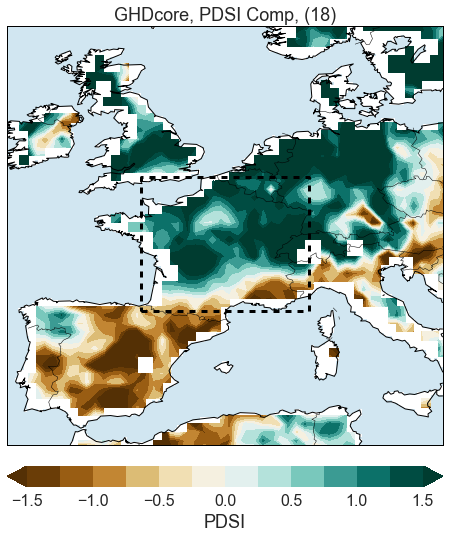

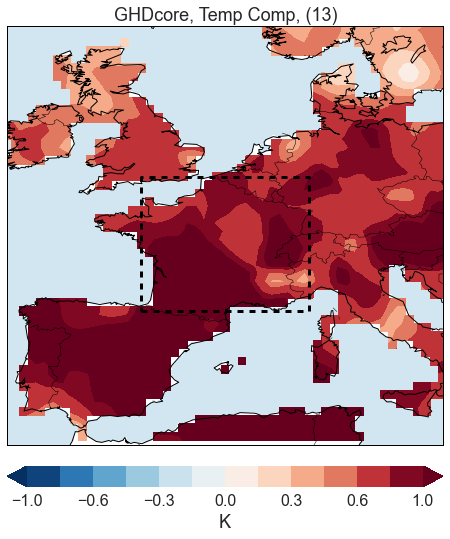

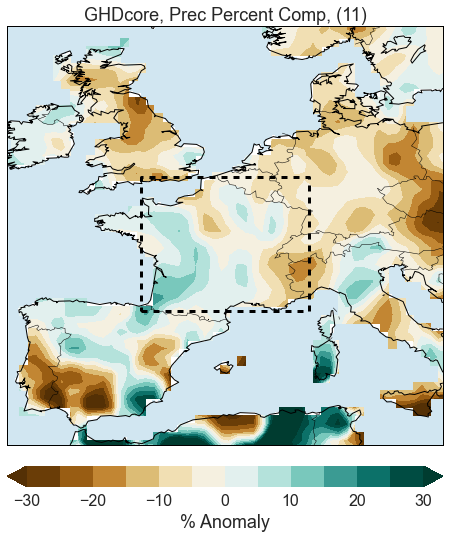

In [8]:
#%%############################################################################
# PDSI Map First.
# Find the locations in the PDSI Dataset
pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0];

# Composite Average
pdsi_comp_all = np.mean(pdsi_recenter[pdsi_locs,:,:],axis=0)

lon_map = lon_pdsi; lat_map = lat_pdsi;
lonlim=np.array([-10,16]);
latlim=np.array([35,60]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
lon_map, lat_map = np.meshgrid(lon_map, lat_map)

# MAP
# Title
#title_txt = ghd_name+', Spearman''s r, Temp ('+mons_ave_txt+')'
title_txt = ghd_name+', PDSI Comp, ('+np.str(np.size(pdsi_locs))+')'
fontdict = {'fontsize': 18}

# Map up composite
# Equidistant Cylindrical
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# equidistant cylindrical
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
#ny = data.shape[0]; nx = data.shape[1]
#lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# draw filled contours.
clevs = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
#clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
clevs=np.asarray(clevs); clevs=clevs*0.25
#cs = m.contourf(x,y,pdsi_comp_all,clevs,cmap=cm.GMT_drywet,extend="both")
cs = m.contourf(x,y,pdsi_comp_all,clevs,cmap=plt.cm.BrBG,extend="both")  # blue green to brown
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PDSI',fontsize=18)
# add title
plt.title(title_txt,fontdict)
plt.show()
#fig.savefig(out_txt, format='svg', dpi=1200) # vector graphics for adobe illustrator 
out_txt = '../figures/step04/pdsi.comp.'+yr_txt+'.n'+np.str(np.size(pdsi_locs))+\
    '.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.eps'
fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator 

#%%############################################################################
# Temp Map
# Choose Season of Temperature
tmp_seas = tmp_JJA_anom; seas_txt='JJA';

# Find the locations in the PDSI Dataset
temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs))==1)[0];

# Composite Average
tmp_comp_all = np.mean(tmp_seas[temp_locs,:,:],axis=0)
lon_map = lon_temp; lat_map = lat_temp;

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical

lon_map, lat_map = np.meshgrid(lon_map, lat_map)

# MAP
# Title
#title_txt = ghd_name+', Spearman''s r, Temp ('+mons_ave_txt+')'
title_txt = ghd_name+', Temp Comp, ('+np.str(np.size(temp_locs))+')'
fontdict = {'fontsize': 18}

# Map up correlation
# Equidistant Cylindrical
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# equidistant cylindrical
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
#ny = data.shape[0]; nx = data.shape[1]
#lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# draw filled contours.
#clevs = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
#clevs = [-1,-.85,-.6,-.45,-.3,-.15,0,.15,.3,.45,.6,.85,1]
clevs = [-1,-.85,-.6,-.45,-.3,-.15,0,.15,.3,.45,.6,.85,1]

#clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
clevs=np.asarray(clevs); clevs=(clevs)
cs = m.contourf(x,y,tmp_comp_all,clevs,cmap=plt.cm.RdBu_r,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('K',fontsize=18)
cbar.ax.tick_params(labelsize=16)
# add title
plt.title(title_txt,fontdict)
plt.show()
#fig.savefig(out_txt, format='svg', dpi=1200) # vector graphics for adobe illustrator 
out_txt = '../figures/step04/temp.comp.'+seas_txt+'.'+yr_txt+\
    '.n'+np.str(np.size(temp_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.eps'
fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator 

#%%############################################################################
# Precip Map, percent
# Choose Season of Precipitation
#prec_MAMJJA = (pre_JJA+pre_MAM); clim_MAMJJA = (pre_JJA_mean+pre_MAM_mean)
#pre_seas = ((pre_JJA-pre_JJA_mean)/pre_JJA_mean)*100; seas_txt='JJA';
pre_seas = (pre_JJA_anom/pre_JJA_mean)*100; seas_txt='JJA';

# Find the locations in the PDSI Dataset
prec_locs=np.where(np.int64(np.in1d(yr_paul,subset_yrs))==1)[0];

# Composite Average
pre_comp_all = np.mean(pre_seas[prec_locs,:,:],axis=0)

lon_map = lon_prec; lat_map = lat_prec;

# already set above
#lonlim=np.array([np.min(lon_map),36]);
#latlim=np.array([30,np.max(lat_map)]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical

lon_map, lat_map = np.meshgrid(lon_map, lat_map)

# MAP
# Title
#title_txt = ghd_name+', Spearman''s r, Temp ('+mons_ave_txt+')'
title_txt = ghd_name+', Prec Percent Comp, ('+np.str(np.size(prec_locs))+')'
fontdict = {'fontsize': 18}

# Map up correlation
# Equidistant Cylindrical
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# equidistant cylindrical
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
#ny = data.shape[0]; nx = data.shape[1]
#lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# draw filled contours.
clevs = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
#clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
clevs=np.asarray(clevs); clevs=(clevs*5)
cs = m.contourf(x,y,pre_comp_all,clevs,cmap=plt.cm.BrBG,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('% Anomaly',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticklabels(fontsize=18)
# add title
plt.title(title_txt,fontdict)
plt.show()
#fig.savefig(out_txt, format='svg', dpi=1200) # vector graphics for adobe illustrator 
out_txt = '../figures/step04/prec.percent.comp.'+seas_txt+'.'+yr_txt+'.n'+np.str(np.size(prec_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.eps'
fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator 